# Team Raj Datathon 2025

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# reading in data
visitation_df=pd.read_csv('data/visitation_data.csv')
climate_df=pd.read_csv('data/climate_data.csv')

In [3]:
# Load original wide data
df = pd.read_csv("data/visitation_data.csv")

# Find the Year/Week columns without renaming anything (case-insensitive)
def _find_col(cols, target):
    for c in cols:
        if str(c).strip().lower() == target:
            return c
    raise KeyError(f"Missing required column '{target}' (case-insensitive).")

YEAR = _find_col(df.columns, "year")
WEEK = _find_col(df.columns, "week")

id_cols = [YEAR, WEEK]
resort_cols = [c for c in df.columns if c not in id_cols]

# --- Long view (temporary; we'll pivot back) ---
# meaning its creating its in years and weeks vertically and having locations in one column so its easier to compute values. 
vis = df.melt(id_vars=id_cols, value_vars=resort_cols,
              var_name="resort", value_name="visitors")

# numeric visitors (float for averaging), clip negatives to 0,
# any non numeric values its turning it in to NaN but this is not necessary in the visitors data.
vis["visitors"] = pd.to_numeric(vis["visitors"], errors="coerce").astype("float64").clip(lower=0)

# === Prev-year based imputation ===
base = vis[[YEAR, WEEK, "resort", "visitors"]].copy()

# prev year, same week
m = vis.copy()
m["_y1"] = m[YEAR] - 1
prev_same = base.rename(columns={YEAR: "_py", WEEK: "_pw", "visitors": "_v_same"})
m = m.merge(prev_same,
            left_on=["resort", "_y1", WEEK],
            right_on=["resort", "_py", "_pw"],
            how="left").drop(columns=["_py", "_pw"])

# prev year, week-1 (week 1 -> 0 won't match; ok)
m["_w1"] = m[WEEK] - 1
prev_before = base.rename(columns={YEAR: "_py2", WEEK: "_pw2", "visitors": "_v_before"})
m = m.merge(prev_before,
            left_on=["resort", "_y1", "_w1"],
            right_on=["resort", "_py2", "_pw2"],
            how="left").drop(columns=["_py2", "_pw2"])

# mean of available lookbacks
m["_impute"] = pd.concat([m["_v_same"], m["_v_before"]], axis=1).mean(axis=1, skipna=True)

# replace zeros where we have an imputed value
mask = m["visitors"].eq(0) & m["_impute"].notna()
m.loc[mask, "visitors"] = m.loc[mask, "_impute"]

# FIRST Year 
m = m.sort_values(["resort", YEAR, WEEK])
first_year = m[YEAR].min()
prev2 = (m.groupby(["resort", YEAR])["visitors"]
           .apply(lambda s: s.shift(1).rolling(2, min_periods=1).mean())
           .reset_index(level=[0,1], drop=True))
mask2 = m[YEAR].eq(first_year) & m["visitors"].eq(0) & prev2.notna()
m.loc[mask2, "visitors"] = prev2[mask2]

# --- Pivot back to original wide shape with original column order ---
visitation_cleaned_data = m.pivot_table(index=id_cols, columns="resort", values="visitors", aggfunc="first").reset_index()
visitation_cleaned_data.columns.name = None
visitation_cleaned_data = visitation_cleaned_data[[*id_cols, *resort_cols]]  # keep exact original order
# dropping the 2020 and 2021 data due to the covid affect
visitation_cleaned_data = visitation_cleaned_data[~visitation_cleaned_data[YEAR].isin([2020, 2021])].copy() 



# saving to a new file so you can view the data.
visitation_cleaned_data.to_csv("data/visitation_data_imputed.csv", index=False) 


In [4]:
# cleaning climate data

# trim pre-2014 data and remove outliers: 2020, 2021
climate_filtered_df = climate_df[
    (climate_df['Year'] >= 2014) & 
    (~climate_df['Year'].isin([2020, 2021]))
]

# get ONLY snow seasons for each year
climate_filtered_df = climate_filtered_df[
    ((climate_filtered_df['Month'] == 6) & (climate_filtered_df['Day'] >= 9)) |
    ((climate_filtered_df['Month'].isin([7,8]   ))) | 
    ((climate_filtered_df['Month'] == 9) & (climate_filtered_df['Day'] <= 21))
    ]

# datetime processing
climate_filtered_df['Date'] = pd.to_datetime(
    dict(year=2000, month=climate_filtered_df['Month'], day=climate_filtered_df['Day'])
)

# adding a week column for each date
start_date = pd.Timestamp(year=2000, month=6, day=9)
climate_filtered_df['DaysSinceJune9'] = (climate_filtered_df['Date'] - start_date).dt.days
climate_filtered_df['Week'] = (climate_filtered_df['DaysSinceJune9'] // 7) + 1
climate_filtered_df.drop(columns='DaysSinceJune9', inplace=True)
climate_filtered_df.drop(columns='Date', inplace=True)

# averaging over each week
week_av_clim_df = climate_filtered_df.groupby(
    ['Bureau of Meteorology station number', 'Year', 'Week']
    ) [[
        'Maximum temperature (Degree C)',
        'Minimum temperature (Degree C)',
        'Rainfall amount (millimetres)'
    ]].mean().reset_index()

# deal with remaining NaN that weren't removed by averaging over each week
# imputing on median (reduces impact of outlier weather conditions)  

cols_to_fill = [
    'Maximum temperature (Degree C)',
    'Minimum temperature (Degree C)',
    'Rainfall amount (millimetres)'
]

station_week_clim_avg = week_av_clim_df.groupby(['Bureau of Meteorology station number', 'Week'])[cols_to_fill].transform('median')
week_av_clim_df[cols_to_fill] = week_av_clim_df[cols_to_fill].fillna(station_week_clim_avg)
climate_filtered_df = week_av_clim_df

# saving to a new file so you can view the data.
climate_filtered_df.to_csv("data/climate_data_filtered_imputed.csv", index=False)

In [5]:
# --- Long format again from imputed wide ---
long = wide.melt(id_vars=id_cols, value_vars=resort_cols,
                 var_name="Resort", value_name="Visitation")

# Ensure integers for year/week
long[YEAR] = pd.to_numeric(long[YEAR], errors="coerce").astype("Int64")
long[WEEK] = pd.to_numeric(long[WEEK], errors="coerce").astype("Int64")

# === Weekly averages by resort ===
weekly_resort_avg = (
    long.groupby([WEEK, "Resort"], as_index=False)["Visitation"].mean()
)

# === Weekly averages of TOTAL visitation (all resorts combined) ===
wide["Total_Visitation"] = wide[resort_cols].sum(axis=1)
weekly_total_avg = (
    wide.groupby(WEEK, as_index=False)["Total_Visitation"].mean()
)

# === Yearly totals by resort ===
yearly_resort_total = (
    long.groupby([YEAR, "Resort"], as_index=False)["Visitation"].sum()
)

# === Yearly total visitation (all resorts combined) ===
yearly_total = (
    wide.groupby(YEAR)[resort_cols].sum().sum(axis=1)
        .reset_index(name="Total_Visitation")
)


NameError: name 'wide' is not defined

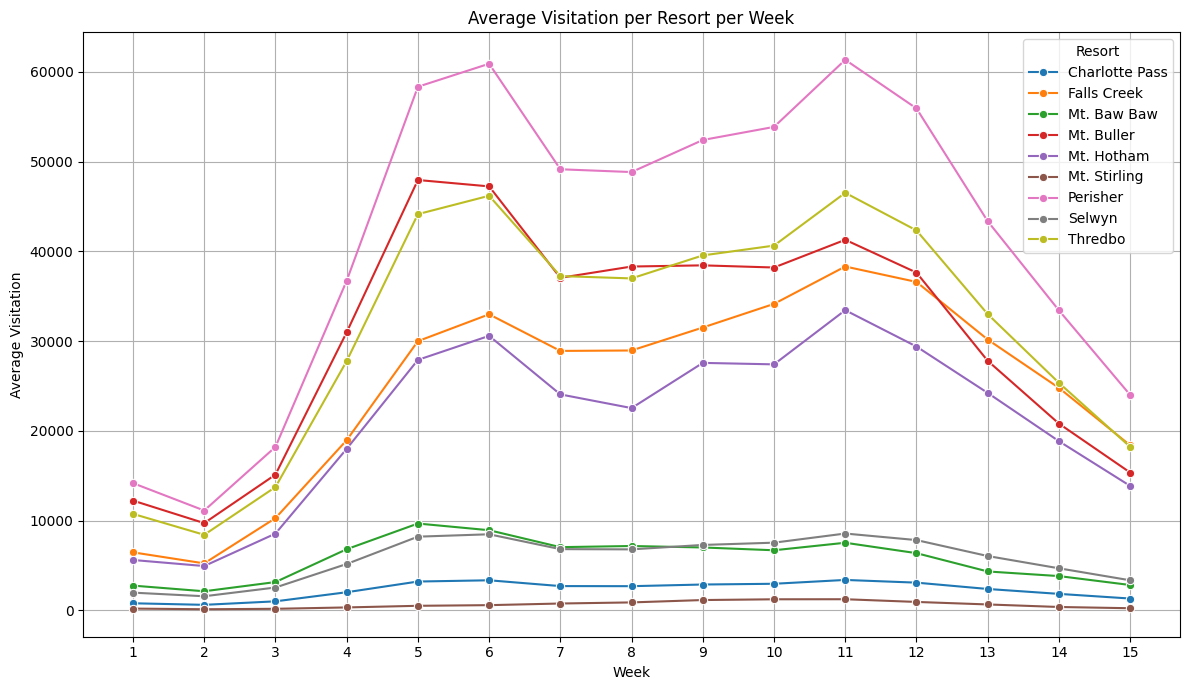

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=weekly_resort_avg, x='Week', y='Visitation', hue='Resort', marker='o')
plt.title('Average Visitation per Resort per Week')
plt.xlabel('Week')
plt.ylabel('Average Visitation')
plt.xticks(sorted(weekly_resort_avg['Week'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()


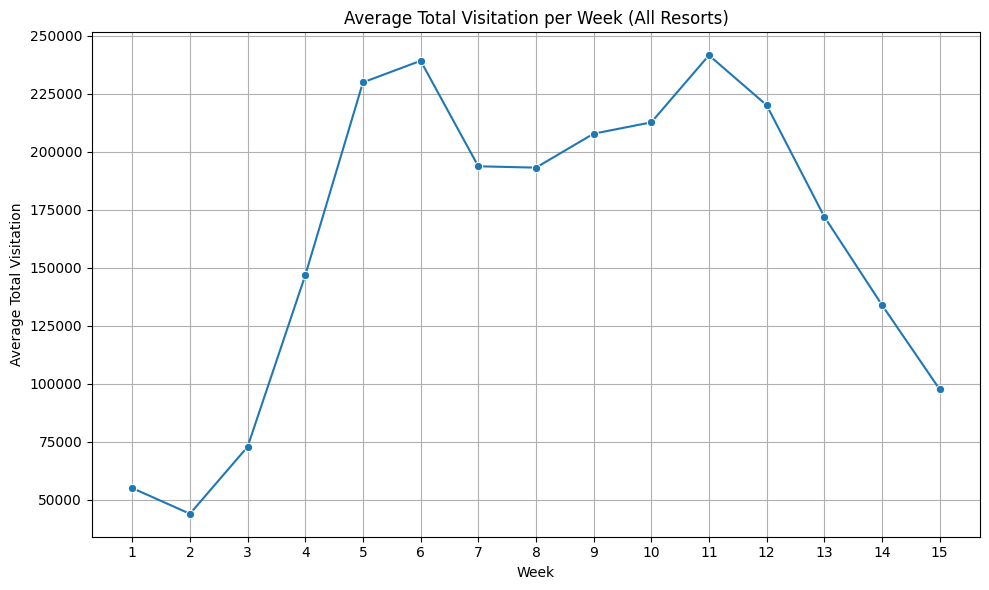

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_total_avg, x='Week', y='Total_Visitation', marker='o')
plt.title('Average Total Visitation per Week (All Resorts)')
plt.xlabel('Week')
plt.ylabel('Average Total Visitation')
plt.xticks(sorted(weekly_total_avg['Week'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()


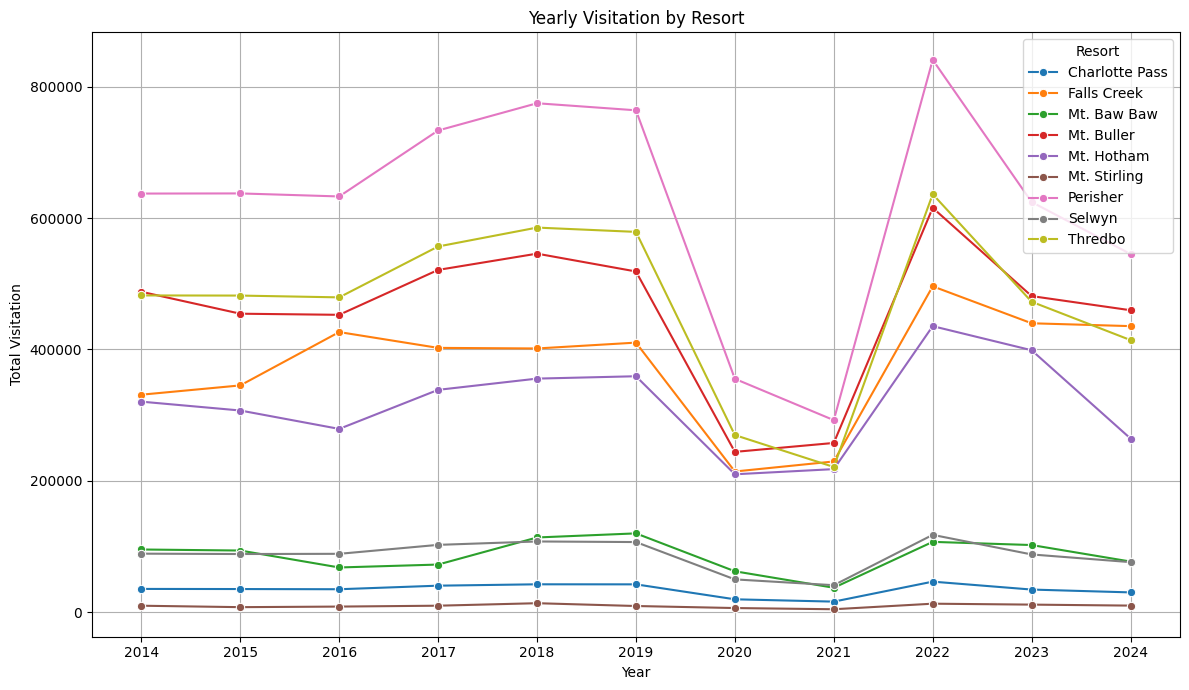

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=yearly_resort_total, x='Year', y='Visitation', hue='Resort', marker='o')
plt.title('Yearly Visitation by Resort')
plt.xlabel('Year')
plt.ylabel('Total Visitation')
plt.xticks(sorted(yearly_resort_total['Year'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()
